<a href="https://colab.research.google.com/github/iashyam/Machine-Learning-First-Repo/blob/main/Regression_of_Old_Car_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [785]:
import pandas as pd
import matplotlib.pyplot as plt
#import simple imputer from sckikit learn
from sklearn.impute import SimpleImputer
#import test train split
from sklearn.model_selection import train_test_split
#import onehot incoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import datetime as dt
#import assential for a linear neural netowork, including sequential model, input, and dense layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
#import min max scaler
from sklearn.preprocessing import MinMaxScaler

In [786]:
train_data = pd.read_csv('sample_data/train.csv', index_col='id')
test_data = pd.read_csv('sample_data/test.csv')

In [787]:
train_x = train_data.copy()

In [788]:
train_x.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [789]:
train_x.nunique()

,0
brand,57
model,1897
model_year,34
milage,6651
fuel_type,7
engine,1117
transmission,52
ext_col,319
int_col,156
accident,2


There are a lot of colors to we can't `encode` them. But if we think it through, `Jet Black` is just `black` and `Royal Blue` is just `blue`.

In [790]:
def recolor(x, n):

    '''
    This is a function to reduce the color columns. It will rename colors like
    Jet Black to Black and catogrizes the colors. It will return a function that
    can be applied to the color column.
    '''

    x.replace('Grey', 'Gray')
    colors = x.value_counts().head(n).index

    def f(color_column):
        for color in colors:
            if color in color_column or color.upper() in color_column:
                return color
        return 'Other'

    return f


int_reame_color = recolor(train_x.int_col, 7)
train_x.int_col = train_x.int_col.apply(int_reame_color)
train_x.int_col.replace('-', 'Other')

ext_rename_color = recolor(train_x.ext_col, 10)
train_x.ext_col = train_x.ext_col.apply(ext_rename_color)

<Axes: xlabel='int_col'>

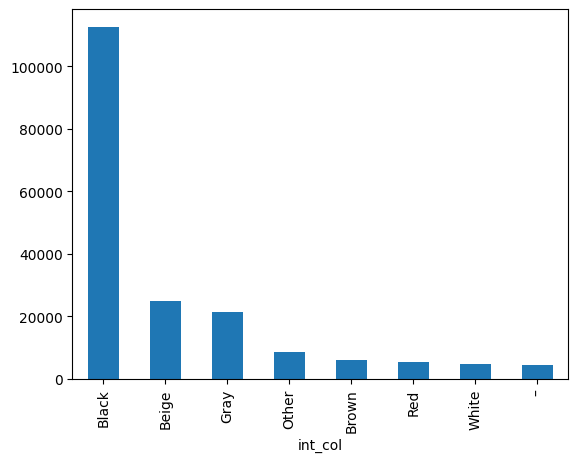

In [791]:
train_x['int_col'].value_counts().plot(kind='bar')

In [792]:
train_x['strength'] = train_x.engine.str.extract(r'(\d{3}\.\d{1}HP)')[0].str[:-2].astype('float')
train_x['cylinder'] = train_x.engine.str.extract(r'(\d{1}\.\d{1}L)')[0].str[:-1].astype('float')

In [793]:
current_year = dt.datetime.now().year

In [794]:
train_x['age'] = current_year - train_x.model_year +1
train_x['milage_per_year'] = train_x.milage / train_x.age

In [795]:
#removing potential outliers
train_x = train_x[train_x['price'] < 1e6].copy()

In [796]:
train_x.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,strength,cylinder,age,milage_per_year
id,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Other,Gray,None reported,Yes,4200,172.0,1.6,18,11833.333333
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,23,6228.260870
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,23,5944.826087
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8,2437.500000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4,1847.000000


In [797]:
brand_by_price = train_x.groupby('brand').mean(numeric_only=True).sort_values('price', ascending=False)['price']
high_luxry_cars = brand_by_price.iloc[:10].index
mid_luxry_cars = brand_by_price.iloc[10:20].index
low_luxry_cars = brand_by_price.iloc[20:].index

In [798]:
def get_luxry_level(x):
    if x in high_luxry_cars:
        return 'high'
    elif x in mid_luxry_cars:
        return 'mid'
    elif x in low_luxry_cars:
        return 'low'

train_x['luxry level'] = train_x.brand.apply(get_luxry_level)

In [799]:
train_x.clean_title.fillna('No', inplace=True)

### Some Machine Learning

In [800]:
float("Nan")

nan

In [801]:
train_x.fuel_type.replace('-', 'not supported', inplace=True)

In [802]:
impute = SimpleImputer(strategy='most_frequent')
train_x.cylinder = impute.fit_transform(train_x.cylinder.values.reshape(-1,1))

In [803]:
impute = SimpleImputer(strategy='mean')
train_x.strength = impute.fit_transform(train_x.strength.values.reshape(-1,1))

In [804]:
train_x.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'strength', 'cylinder', 'age', 'milage_per_year',
       'luxry level'],
      dtype='object')

In [805]:
train_y = train_x['price']
train_x = train_x.drop('price', axis=1)

In [806]:
train_y.shape

(188385,)

In [807]:
numeric_columns = ['age']
categorical_columns = ['luxry level','clean_title']

train_data = pd.concat([train_x[numeric_columns], pd.get_dummies(train_x[categorical_columns])], axis=1)
train_data

,age,luxry level_high,luxry level_low,luxry level_mid,clean_title_No,clean_title_Yes
id,,,,,,
0,18,False,True,False,False,True
1,23,False,True,False,False,True
2,23,False,True,False,False,True
3,8,False,False,True,False,True
4,4,False,False,True,False,True
...,...,...,...,...,...,...
188528,8,False,True,False,False,True
188529,7,False,False,True,False,True
188530,4,False,False,True,False,True


In [808]:
train_y_copy = train_y.copy()
train_x = train_data.copy()

### Neural Network

In [815]:
train_data[numeric_columns] =  MinMaxScaler().fit_transform(train_data[numeric_columns])
train_y = MinMaxScaler().fit_transform(train_y.values.reshape(-1,1))

In [816]:
train_X, test_X, train_Y, test_Y = train_test_split(train_data, train_y, test_size=0.1, shuffle=True)

In [817]:
train_Y.shape

(169546, 1)

In [821]:
def make_net():
    model = Sequential()
    model.add(Input(shape=(train_data.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model



In [822]:
model = make_net()
model.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [823]:
history = model.fit(train_X, train_Y, epochs=30, batch_size=32)

Epoch 1/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 3.2936e-04 - loss: 0.0049
Epoch 2/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 2.8782e-04 - loss: 0.0035
Epoch 3/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 2.7976e-04 - loss: 0.0034
Epoch 4/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 2.6731e-04 - loss: 0.0035
Epoch 5/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 2.8093e-04 - loss: 0.0033
Epoch 6/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 2.5897e-04 - loss: 0.0034
Epoch 7/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 2.6798e-04 - loss: 0.0034
Epoch 8/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 2.3057e-04 - loss: 0.0034
Epoch 9/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 3.5098e-04 - loss: 0.0033
Epoch 10/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 2.4751e-04 - loss: 0.0034
Epoch 11/30
5299/5299 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 2.9388e

In [ ]:
#plot loss over epchos
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_2 = RandomForestRegressor()
model_2.fit(train_X, train_Y)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
m = r2_score(model_2.predict(test_X), test_Y)

In [ ]:
m <4245918976.0000

In [ ]:
m